In [82]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from scipy.optimize import minimize
import sys
import pandas as pd
import numpy as np

class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, scale, batch_size):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.scale = scale
        self.batch_size = batch_size
        self.gauss_pr = GaussianProcessRegressor()
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []
        
    def _get_expected_improvement(self, x_new):

        # Using estimate from Gaussian surrogate instead of actual function for 
        # a new trial data point to avoid cost 
 
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array([x_new]), return_std=True)
        sigma_y_new = sigma_y_new.reshape(-1,1)
        if sigma_y_new == 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for 
        # entire prior distribution to avoid cost
        
        mean_y = self.gauss_pr.predict(self.x_init)
        max_mean_y = np.max(mean_y)
        z = (mean_y_new - max_mean_y) / sigma_y_new
        exp_imp = (mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        
        return exp_imp
    
    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
        
    def _get_next_probable_point(self):
            min_ei = float(sys.maxsize)
            x_optimal = None 
            
            # Trial with an array of random data points
            
            for x_start in (np.random.random((self.batch_size,self.x_init.shape[1])) * self.scale):
                response = minimize(fun=self._acquisition_function, x0=x_start, method='L-BFGS-B')
                if response.fun < min_ei:
                    min_ei = response.fun
                    x_optimal = response.x
            
            return x_optimal, min_ei

    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array(y), axis = 0)
  
    def optimize(self):
        y_max_ind = np.argmax(self.y_init)
        y_max = self.y_init[y_max_ind]
        optimal_x = self.x_init[y_max_ind]
        optimal_ei = None
        for i in range(self.n_iter):
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array([x_next]))
            self._extend_prior_with_posterior_data(x_next,y_next)
            
            if y_next[0] > y_max:
                y_max = y_next[0]
                optimal_x = x_next
                optimal_ei = ei

            if i == 0:
                 prev_x = x_next
            else:
                self.distances_.append(np.linalg.norm(prev_x - x_next))
                prev_x = x_next
            
            self.best_samples_ = self.best_samples_.append({"y": y_max, "ei": optimal_ei},ignore_index=True)
        
        return optimal_x, y_max

In [83]:
def costly_function(x):
    return np.sin(x[:, 0]) + np.cos(2 * x[:, 1])

sample_x = np.linspace(-2 * np.pi, 2 * np.pi, 100).reshape(50, 2)
sample_y = costly_function(x)



/tmp/ipykernel_29453/3695246747.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.best_samples_ = self.best_samples_.append({"y": y_max, "ei": optimal_ei},ignore_index=True)
/tmp/ipykernel_29453/3695246747.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.best_samples_ = self.best_samples_.append({"y": y_max, "ei": optimal_ei},ignore_index=True)
/tmp/ipykernel_29453/3695246747.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.best_samples_ = self.best_samples_.append({"y": y_max, "ei": optimal_ei},ignore_index=True)
/tmp/ipykernel_29453/3695246747.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.best_sam

<AxesSubplot:>

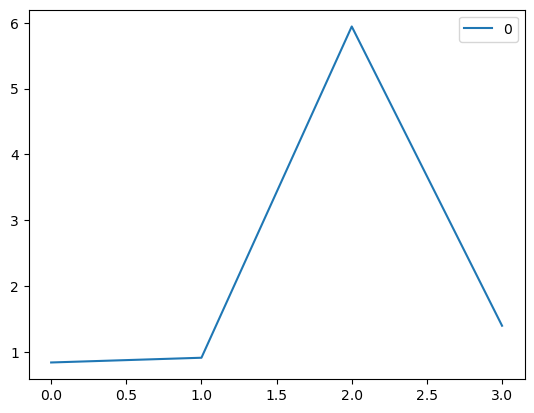

In [85]:
bopt = BayesianOptimizer(target_func=costly_function, x_init=sample_x, y_init=sample_y, n_iter=200, scale=10, batch_size=30)
bopt.optimize()

pd.DataFrame(bopt.distances_).plot()

In [ ]:
bopt.best_samples_['y'].plot()

In [ ]:
bopt.best_samples_['ei'].plot()